In [1]:
import os
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import string
import skimpy
from ydata_profiling import ProfileReport
import re
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import missingno as msno
import datetime
import time
from tqdm import trange
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, silhouette_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import tensorflow as tf
# import tensorflow_datasets as tfds
# from keras.preprocessing.text import Tokenizer
# from keras.utils import pad_sequences
# import keras_tuner
# from keras.utils.vis_utils import plot_model

import transformers
from transformers import XLNetTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.tensorboard import SummaryWriter
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification, XLNetConfig, TFXLNetModel, XLNetForSequenceClassification
from transformers import AdamW, get_scheduler

import lime
from lime.lime_text import LimeTextExplainer

import shap

import sys
sys.path.append("/home/alexxgo21/workspace/thesis/modules")
from preprocess_raw_html import preprocess_raw_html

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None) 

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Load the Dataset

In [2]:
df = pd.read_parquet("../dataset/philosophy-qna-with-gpt35answer_v1.parquet")
df = df[["view_count","answer_count","is_accepted","answer_score","answer_creation_date","answers","question_score","question_creation_date","link","question","title","gpt35_0125_ans"]]

In [3]:
# def get_gpt_response(text):
#     return re.sub(r"\n", " ", text["choices"][0]["message"]["content"])

In [4]:
# print(preprocess_raw_html(df[df["answer_count"]==1]["answers"].iloc[108][0]))

In [5]:
# print(" ".join([word for word in txt.split() if word not in stopwords.words("english")]))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   view_count              2541 non-null   int64 
 1   answer_count            2541 non-null   int64 
 2   is_accepted             2541 non-null   object
 3   answer_score            2541 non-null   object
 4   answer_creation_date    2541 non-null   object
 5   answers                 2541 non-null   object
 6   question_score          2541 non-null   int64 
 7   question_creation_date  2541 non-null   int64 
 8   link                    2541 non-null   object
 9   question                2541 non-null   object
 10  title                   2541 non-null   object
 11  gpt35_0125_ans          2541 non-null   object
dtypes: int64(4), object(8)
memory usage: 238.3+ KB


In [7]:
# limit the number of answers per question to 2
def select_random_index(arr,max_ans=2):
    if len(arr) > max_ans:
        return random.sample(range(len(arr)), max_ans)
    return None

def update_columns_based_on_random_index(row):
    if row["temp_index"] is not None:
        row["answers"] = np.array(row["answers"])[row["temp_index"]]
        row["is_accepted"] = np.array(row["is_accepted"])[row["temp_index"]]
        row["answer_score"] = np.array(row["answer_score"])[row["temp_index"]]
        row["answer_creation_date"] = np.array(row["answer_creation_date"])[row["temp_index"]]
    return row

df["temp_index"] = df["answers"].apply(lambda x: select_random_index(x))
df = df.apply(lambda x: update_columns_based_on_random_index(x), axis=1)
df = df.drop(columns=["temp_index"])

In [8]:
df_ans_exploded = df[["answers","question","title","gpt35_0125_ans"]]
df_ans_exploded = df_ans_exploded.explode("answers").reset_index(drop=True)

In [9]:
# preprocess the raw html
df_ans_exploded["answers"] = df_ans_exploded["answers"].apply(preprocess_raw_html)

In [10]:
def get_gpt_response(text):
    return re.sub(r"\n", " ", text["choices"][0]["message"]["content"])

df_ans_exploded["gpt_response"] = df_ans_exploded["gpt35_0125_ans"].apply(get_gpt_response)

In [11]:
# df_ans_exploded = df_ans_exploded.sample(frac=1)

In [12]:
df_ans_exploded.head(n=1)

answers  \
0  This is a great question and I hope I won't be the only person to grapple with it. There must be a calculation that balances the pain and effort of examining another's life with the cost of not doing so.  The argument would seem to be that there is little to no cost associated with leaving others to their unreflective state and substantial cost to examining them.  If so, we would be advised to let sleeping dogs lie. One method to alter the calculation would be to find a benefit that both parties could share which will tip the scales back toward examination.  No doubt Socrates would point to the general improvement to the state of Athens as a positive good that might arise from general introspection.  If bad habits of thought are routinely subject to the light of reason and analysis, perhaps they will die out.  And if Athenians in general are less subject to bad reasoning, they will be able to make wise decisions about their city and fellow citizens. But I imagine there are deeper reasons to examine the lives of others.  In my experience, exploration of how another person thinks gives rise to deeper friendship with that person.  How can anyone put a price on friendship?  For a good friend would you not make great sacrifices?  And though I can't see how to quantify it, I feel like my life is better simply for having a handful of good friends. I plan to consider this question more in the future—it has great value.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              question  \
0  <p>Socrates continually admonished his interlocutors to become more introspective, arguing passionately for self-examination:</p>\n\n<blockquote>\n  <p>The unexamined life is not worth living.</p>\n</blockquote>\n\n<p>But an examined life is painful, and necessitates an involvement with real problems. This is why it's worth living -- the unreflective are easily trapped into a living death of the mind by mythology, as the reflective sometimes are by ideology. In both cares we are deadened, sleepwalking through our lives blind and deaf, incapable of interacting with the world as it actually is much less imagining the world as it should be.</p>\n\n<p>Now, we know of course that Socrates did not refrain from commenting on the generally unreflective character of his fellow Athenians. This is really the heart of my question. Certain reactionary critics might suggest that it's all well and good to closely examine one's own beliefs and values, but why should you go about examining the beliefs and values of others?</p>\n   

                                                 title  \
0  Are the unexamined lives of others worth examining?   

                                                                                                                                                                                                                                                                                                                                                                         

### Text Preprocessing

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^0-9a-zA-Z]+", " ", text)
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

def preprocess_text_remove_nums(text):
    text = text.lower()
    text = re.sub("[^0-9a-zA-Z]+", " ", text)
    text = re.sub("\d+", " ", text)
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

In [14]:
# df_ans_exploded["answers"] = df_ans_exploded["answers"].apply(preprocess_text_remove_nums)
# df_ans_exploded["gpt_response"] = df_ans_exploded["gpt_response"].apply(preprocess_text_remove_nums)

In [15]:
df_ans_exploded["answers"].nunique()

4109

In [16]:
df_ans_exploded["gpt_response"].nunique()

2541

### Data splitting

In [17]:
human_response = list(df_ans_exploded["answers"].drop_duplicates())
gpt_response = list(df_ans_exploded["gpt_response"].drop_duplicates())

human_response_remove_nums = [preprocess_text_remove_nums(text) for text in human_response]
gpt_response_remove_nums = [preprocess_text_remove_nums(text) for text in gpt_response]

human_response = [preprocess_text(text) for text in human_response]
gpt_response = [preprocess_text(text) for text in gpt_response]

Y_nums_removed = ["human-generated" for _ in range(len(human_response_remove_nums))] + ["gpt-generated" for _ in range(len(gpt_response_remove_nums))]
X_nums_removed = human_response_remove_nums + gpt_response_remove_nums

X_nums_removed = np.array(X_nums_removed)
Y_nums_removed  = np.array(Y_nums_removed )

Y = ["human-generated" for _ in range(len(human_response))] + ["gpt-generated" for _ in range(len(gpt_response))]
X = human_response + gpt_response

X = np.array(X)
Y  = np.array(Y)


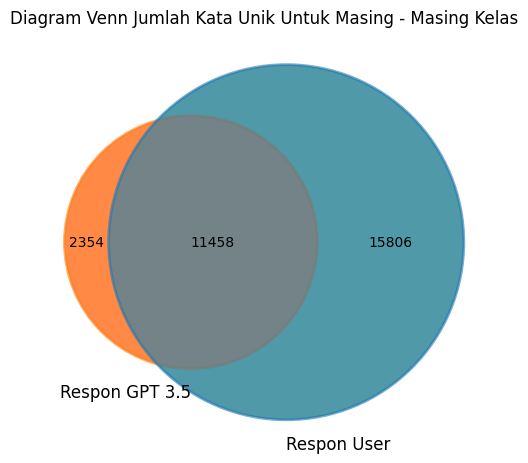

In [18]:
from matplotlib_venn import venn3,venn2,venn2_circles

h_response_remove_nums = [t for i in human_response_remove_nums for t in i.split()]
g_response_remove_nums = [t for i in gpt_response_remove_nums for t in i.split()]

human_set = set(h_response_remove_nums)
gpt_set = set(g_response_remove_nums)

plt.figure(figsize=(6,15))
out = venn2([gpt_set,human_set],('Respon GPT 3.5','Respon User'))
out = venn2_circles(subsets=[gpt_set,human_set],linewidth=1)

# circle format
for circle, color in zip(out, ["#ff7f0e","#1f77b4"]):
    circle.set_lw(2.0)
    # circle.set_ls('dotted')
    circle.set_alpha(0.6)
    circle.set_color(color)


plt.title("Diagram Venn Jumlah Kata Unik Untuk Masing - Masing Kelas")
plt.show()

In [19]:
from collections import Counter

h = Counter(h_response_remove_nums)
g = Counter(g_response_remove_nums)

In [20]:
# train test split using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

for train_index, test_index in sss.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    X_train_nums_removed, X_test_nums_removed = X_nums_removed[train_index], X_nums_removed[test_index]
    Y_train_nums_removed, Y_test_nums_removed = Y_nums_removed[train_index], Y_nums_removed[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
for val_index, test_index in sss.split(X_test,Y_test):
    X_val, X_test = X_test[val_index], X_test[test_index]
    Y_val, Y_test = Y_test[val_index], Y_test[test_index]
    X_val_nums_removed, X_test_nums_removed = X_test_nums_removed[val_index], X_test_nums_removed[test_index]
    Y_val_nums_removed, Y_test_nums_removed = Y_test_nums_removed[val_index], Y_test_nums_removed[test_index]

In [21]:
len(X_train_nums_removed), len(X_val_nums_removed), len(X_test_nums_removed)

(4655, 997, 998)

In [22]:
len([i for i in Y_train_nums_removed if i == "human-generated"]), len([i for i in Y_train_nums_removed if i == "gpt-generated"])

(2876, 1779)

In [23]:
len([i for i in Y_val_nums_removed if i == "human-generated"]), len([i for i in Y_val_nums_removed if i == "gpt-generated"])

(616, 381)

In [24]:
len([i for i in Y_test_nums_removed if i == "human-generated"]), len([i for i in Y_test_nums_removed if i == "gpt-generated"])

(617, 381)

In [25]:
# tf=TfidfVectorizer()
# X_train_tf = tf.fit_transform(X_train)

# # X_test_tf = tf.transform(X_test)
# feature_names = tf.get_feature_names_out()

# tfidf_scores = X_train_tf.sum(axis=0).A1  
# df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores})
# df_sorted = df.sort_values(by='tfidf_score', ascending=False)
# df_sorted.head(10)

In [26]:
# X_test_tf = tf.transform(X_test)
# feature_names = tf.get_feature_names_out()

# tfidf_scores = X_test_tf.sum(axis=0).A1  
# df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores})
# df_sorted = df.sort_values(by='tfidf_score', ascending=False)
# df_sorted.head(10)

### TF-IDF

In [27]:
# feature extraction with TF-IDF
vectorizer=TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_val_tf = vectorizer.transform(X_val)
X_test_tf = vectorizer.transform(X_test)

# encode the label
label_encoder = LabelEncoder()

Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

# feature extraction with TF-IDF
vectorizer=TfidfVectorizer()
X_train_tf_nr = vectorizer.fit_transform(X_train_nums_removed)
X_val_tf_nr = vectorizer.transform(X_val_nums_removed)
X_test_tf_nr = vectorizer.transform(X_test_nums_removed)

In [28]:
# encode label
label_encoder = LabelEncoder()

Y_train_encoded_nr = label_encoder.fit_transform(Y_train_nums_removed)
Y_val_encoded_nr = label_encoder.transform(Y_val_nums_removed)
Y_test_encoded_nr = label_encoder.transform(Y_test_nums_removed)

### SVC

In [ ]:
param_range = 2 * np.logspace(-5, 5, num=11)

In [ ]:
svc = SVC(probability=True) # rbf

# Hyperparameter grid
param_grid = {"C": param_range, "gamma":param_range}

# Grid search
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2)

# Fit and evaluate
model = grid_search.fit(X_train_tf_nr,Y_train_encoded_nr)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [27]:
# best_params

In [29]:
import joblib

svm = joblib.load('./models/SVC.joblib')

In [30]:
Y_train_pred = svm.predict(X_train_tf_nr)
accuracy = accuracy_score(Y_train_encoded_nr, Y_train_pred)
print("training set")
print("Accuracy:", accuracy)
print(classification_report(Y_train_encoded_nr,Y_train_pred))
print(confusion_matrix(Y_train_encoded_nr,Y_train_pred))

training set
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1779
           1       1.00      1.00      1.00      2876

    accuracy                           1.00      4655
   macro avg       1.00      1.00      1.00      4655
weighted avg       1.00      1.00      1.00      4655

[[1779    0]
 [   0 2876]]


In [31]:
label_encoder.classes_

array(['gpt-generated', 'human-generated'], dtype='<U15')

In [32]:
Y_val_pred = svm.predict(X_val_tf_nr)
accuracy = accuracy_score(Y_val_encoded_nr, Y_val_pred)
precision = precision_score(Y_val_encoded_nr, Y_val_pred)
recall = recall_score(Y_val_encoded_nr, Y_val_pred)
f1 = f1_score(Y_val_encoded_nr, Y_val_pred)
print("validation set")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(classification_report(Y_val_encoded_nr,Y_val_pred))
print(confusion_matrix(Y_val_encoded_nr,Y_val_pred))

Y_test_pred = svm.predict(X_test_tf_nr)
accuracy = accuracy_score(Y_test_encoded_nr, Y_test_pred)
precision = precision_score(Y_test_encoded_nr, Y_test_pred)
recall = recall_score(Y_test_encoded_nr, Y_test_pred)
f1 = f1_score(Y_test_encoded_nr, Y_test_pred)
print("\n\ntest set")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(classification_report(Y_test_encoded_nr,Y_test_pred))
print(confusion_matrix(Y_test_encoded_nr,Y_test_pred))

validation set
Accuracy: 0.9598796389167502
Precision: 0.9585987261146497
Recall: 0.9772727272727273
F1 Score: 0.9678456591639871
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       381
           1       0.96      0.98      0.97       616

    accuracy                           0.96       997
   macro avg       0.96      0.95      0.96       997
weighted avg       0.96      0.96      0.96       997

[[355  26]
 [ 14 602]]


test set
Accuracy: 0.9559118236472945
Precision: 0.9689034369885434
Recall: 0.9594813614262561
F1 Score: 0.9641693811074918
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       381
           1       0.97      0.96      0.96       617

    accuracy                           0.96       998
   macro avg       0.95      0.95      0.95       998
weighted avg       0.96      0.96      0.96       998

[[362  19]
 [ 25 592]]


##### XAI

In [33]:
svm_incorrect_predictions_idx = np.where(Y_test_encoded_nr != Y_test_pred)[0]
svm_incorrect_X = X_test_nums_removed[svm_incorrect_predictions_idx]
svm_incorrect_X_tf = X_test_tf_nr[svm_incorrect_predictions_idx]
svm_incorrect_X_Y_actual = Y_test_nums_removed[svm_incorrect_predictions_idx]
svm_incorrect_X_Y_pred = Y_test_pred[svm_incorrect_predictions_idx]
svm_incorrect_X_len = [len(i) for i in svm_incorrect_X]

correct_predictions_idx = np.where(Y_test_encoded_nr == Y_test_pred)[0]
correct_X = X_test_nums_removed[correct_predictions_idx]
correct_X_tf = X_test_tf_nr[correct_predictions_idx]
correct_X_Y_actual = Y_test_nums_removed[correct_predictions_idx]
correct_X_Y_pred = Y_test_pred[correct_predictions_idx]
correct_X_len = [len(i) for i in correct_X]

In [34]:
svm_fp = [i for i in range(len(svm_incorrect_X_Y_actual)) if svm_incorrect_X_Y_actual[i] == "gpt-generated"]
svm_fn = [i for i in range(len(svm_incorrect_X_Y_actual)) if svm_incorrect_X_Y_actual[i] == "human-generated"]

In [35]:
svm_incorrect_X[svm_fp]

array(['quote lao tzu reflects idea personal growth transformation self discovery letting go preconceived notions oneself releasing attachments current identities limitations one opens potential become something greater fully realize one possibilities quote encourages embracing change unknown suggests relinquishing past open new experiences one evolve better version',
       'bolded last sentence states making political decision legally binding soldiers go war would make mockery legal system means forcing soldiers participate war even believe immoral conscience goes principles justice fairness individual rights supposed upheld legal system would make mockery legal system would forcing individuals act moral judgment personal conscience could lead moral distress psychological harm potential violations human rights legal system meant protect individual freedoms rights coercing individuals participate actions believe morally wrong undermines foundations legal system summary statement argui

In [36]:
# for i in range(len(incorrect_X)):
#     print(i,end="\n")
#     print(np.argsort(incorrect_X_len)[i],end="\n")
#     print(f"{incorrect_X[np.argsort(incorrect_X_len)[i]]}\npredicted class: {incorrect_X_Y_actual[np.argsort(incorrect_X_len)[i]]}\nactual class: {'gpt-generated' if incorrect_X_Y_pred[np.argsort(incorrect_X_len)[i]] == 0 else 'human-generated'}",end="\n\n")

In [36]:
idxes = [ i for i in range(len(correct_X))]

In [37]:
sorted_correct_X = sorted(list(zip(correct_X,correct_X_Y_actual,correct_X_Y_pred,idxes)), key=lambda item: len(item[0]))

In [38]:
c = 0
for i in range(20,len(sorted_correct_X)):
    text,actual,pred,idx = sorted_correct_X[i]
    if actual=="gpt-generated":
        print(i,end="\n")
        print(idx,end="\n")
        print(f"{text}\nactual class: {actual}\npredicted class: {'gpt-generated' if pred == 0 else 'human-generated'}",end="\n\n")
        c+=1
    
    if c==20:
        break

59
263
using term contextual concept refer idea term captures essence concept flexible adapted fit specific context situation like soup becomes hammer absence traditional tools shorter simple accessible communicating laypeople
actual class: gpt-generated
predicted class: gpt-generated

60
387
given already statement b use transitive property equality show b transitive property states b b c c case use transitive property fact b conclude b proof given b step symmetry b applying symmetry property states b b show b
actual class: gpt-generated
predicted class: gpt-generated

61
857
seems like miscommunication b per conversation provided b actually likes chocolate cake simply said response question misunderstood b response dislike chocolate cake important clarify miscommunications like avoid confusion
actual class: gpt-generated
predicted class: gpt-generated

85
711
greek word translated english commanding faculty ruling faculty context stoic philosophy refers rational moral part soul respo

In [39]:
idx = 711 # 263
correct_X[idx], correct_X_Y_actual[idx], correct_X_Y_pred[idx]

('greek word translated english commanding faculty ruling faculty context stoic philosophy refers rational moral part soul responsible making decisions judgments faculty plays crucial role determining person character directing actions towards virtue excellence',
 'gpt-generated',
 0)

In [61]:
text="decisions"
h[text],g[text]

(89, 168)

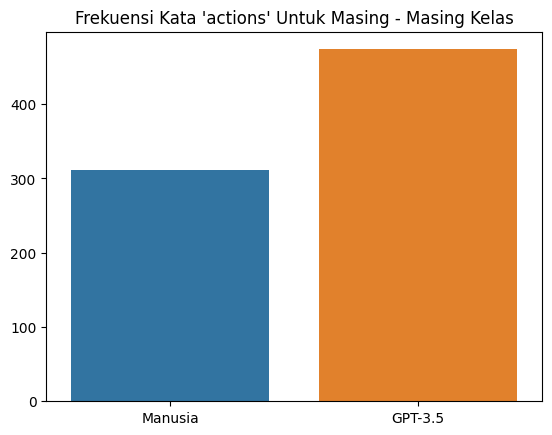

In [45]:
sns.barplot(x=["Manusia","GPT-3.5"],y=[h[text],g[text]])
plt.title(f"Frekuensi Kata '{text}' Untuk Masing - Masing Kelas")
plt.show()

##### Permutation Explainer

In [ ]:
# def make_predictions(X):
#     X = vectorizer.transform(X).toarray()
#     preds = svm.predict_proba(X)
#     return preds

# masker = shap.maskers.Text(tokenizer=r"\W+")
# explainer = shap.PermutationExplainer(make_predictions, masker=masker,output_names=["gpt-generated","human-generated"])

In [45]:
# shap_values = explainer([correct_X[idx]])

In [120]:
# shap.text_plot(shap_values)

##### Partition Explainer

In [40]:
def make_predictions_svm(X):
    X = vectorizer.transform(X).toarray()
    preds = svm.predict_proba(X)
    return preds

In [66]:
make_predictions_svm([correct_X[idx]])

array([[0.93845563, 0.06154437]])

In [41]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions_svm, masker=masker,output_names=["gpt-generated","human-generated"])

In [68]:
shapv = explainer([correct_X[idx]])

In [69]:
shap.plots.text(shapv)

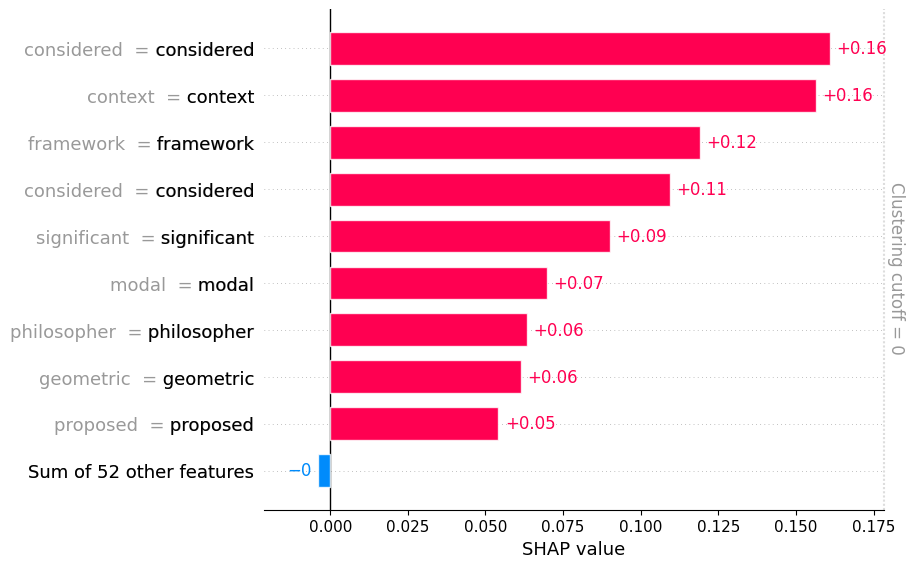

In [70]:
shap.plots.bar(shapv[0,:,0], max_display=10, order=shap.Explanation.argsort.flip, clustering_cutoff=0)

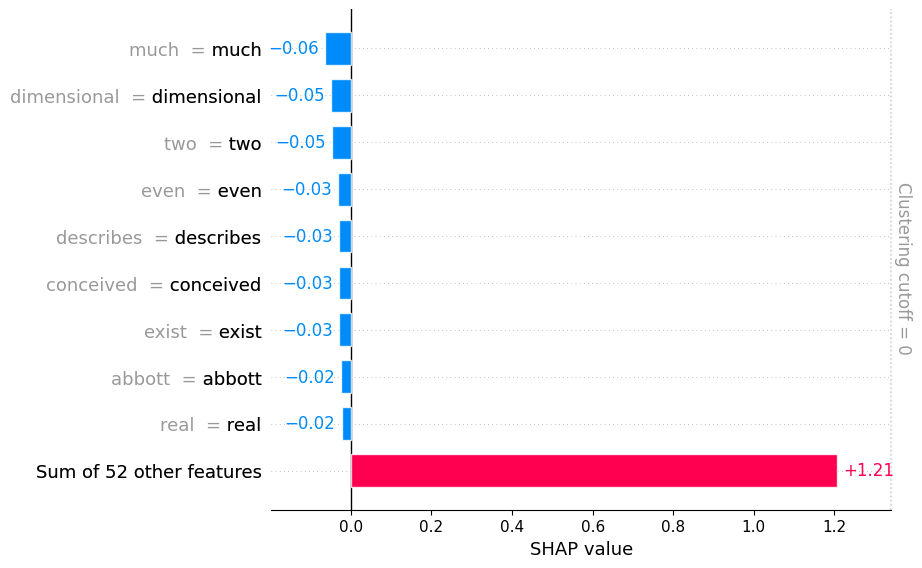

In [71]:
shap.plots.bar(shapv[0,:,0], max_display=10, order=shap.Explanation.argsort, clustering_cutoff=0)

In [66]:
h["autobiography"], g["autobiography"]

(2, 3)

##### LIME

In [87]:
c = make_pipeline(vectorizer, svm)

ls_X_test= list(correct_X)

class_names = {0: "gpt-generated", 1:"human-generated"}

In [92]:
correct_X[710]

'according modal realism proposed philosopher david lewis possible worlds conceived existing independently actual world framework possible worlds treated concrete entities exist much actual world apply view book flatland edwin abbott abbott describes two dimensional world inhabited geometric shapes according modal realism flatland would indeed considered exist possible world context modal realism possible worlds considered equally real even different world significant ways'

In [76]:
test_svm_text

array(['far know roger scruton write autobiography written many books various topics including philosophy aesthetics politics appear autobiography authored possible reference wikipedia article may incorrect based misinformation',
       'proposed translations contain errors correct translations fol true everyone owns car x c x x either someone owns car one owns car x c x x x c correct translations first translation negated universal quantification everyone owns car resulting true everyone owns car second translation used existential quantifier state either someone owns car one owns car'],
      dtype='<U10948')

In [94]:
# create the LIME explainer
LIME_explainer = LimeTextExplainer(class_names=class_names)

# explain the chosen prediction 
LIME_exp = LIME_explainer.explain_instance(ls_X_test[711], c.predict_proba)
# print results
print('Philosophy answer: ', ls_X_test[711])
print('Probability human-generated = ', c.predict_proba([ls_X_test[711]]).round(3)[0,1])
# print('True class: %s' % (correct_X_Y_actual[idx]))

Philosophy answer:  greek word translated english commanding faculty ruling faculty context stoic philosophy refers rational moral part soul responsible making decisions judgments faculty plays crucial role determining person character directing actions towards virtue excellence
Probability human-generated =  0.094


In [95]:
# # show the explainability results with highlighted text
# # LIME_exp.save_to_file('SVC.html')
LIME_exp.show_in_notebook()

In [97]:
h["refers"],g["refers"]

(134, 313)

### Xlnet

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [40]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
# tokenized_batch = tokenizer(
#     batch, 
#     truncation=True, 
#     padding="max_length", 
#     max_length=128, 
#     return_tensors="pt",
#     return_attention_mask=True,
#     return_token_type_ids=False,
#     add_special_tokens=True
# )

max_length = 512

def xlnet_tokenizer(sent,tokenizer):
    return tokenizer(
                sent, 
                truncation=True, 
                padding="max_length", 
                max_length=max_length, 
                return_tensors="pt",
                return_attention_mask=True,
                return_token_type_ids=False,
                add_special_tokens=True
            )

train_sentences = tokenizer(
    X_train_nums_removed.tolist(), 
    truncation=True, 
    padding="max_length", 
    max_length=max_length, 
    return_tensors="pt",
    return_attention_mask=True,
    return_token_type_ids=False,
    add_special_tokens=True
)

val_sentences = tokenizer(
    X_val_nums_removed.tolist(), 
    truncation=True, 
    padding="max_length", 
    max_length=max_length, 
    return_tensors="pt",
    return_attention_mask=True,
    return_token_type_ids=False,
    add_special_tokens=True
)

test_sentences = tokenizer(
    X_test_nums_removed.tolist(), 
    truncation=True, 
    padding="max_length", 
    max_length=max_length, 
    return_tensors="pt",
    return_attention_mask=True,
    return_token_type_ids=False,
    add_special_tokens=True
)

# train_sentences = [sentence + "[SEP] [CLS]" for sentence in X_train_nums_removed]
# val_sentences = [sentence + "[SEP] [CLS]" for sentence in X_val_nums_removed]
# test_sentences = [sentence + "[SEP] [CLS]" for sentence in X_test_nums_removed]

# tokenized_train = [tokenizer.tokenize(sent) for sent in train_sentences]
# tokenized_val = [tokenizer.tokenize(sent) for sent in val_sentences]
# tokenized_test = [tokenizer.tokenize(sent) for sent in test_sentences]

# MAX_LEN = 128
# train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]
# train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# val_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_val]
# val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]
# test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# # Create attention masks
# train_masks = []
# # Create a mask of 1s for each token followed by 0s for padding
# for seq in train_input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   train_masks.append(seq_mask)
# train_input_ids = np.array(train_input_ids)
# train_masks = np.array(train_masks)

# # Create attention masks
# val_masks = []
# # Create a mask of 1s for each token followed by 0s for padding
# for seq in val_input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   val_masks.append(seq_mask)
# val_input_ids = np.array(val_input_ids)
# val_masks = np.array(val_masks)

# # Create attention masks
# test_masks = []
# # Create a mask of 1s for each token followed by 0s for padding
# for seq in test_input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   test_masks.append(seq_mask)
# test_input_ids = np.array(test_input_ids)
# test_masks = np.array(test_masks)

In [41]:
# Convert all of our data into torch tensors, the required datatype for the model

# train_inputs = torch.tensor(list(train_input_ids))
# validation_inputs = torch.tensor(list(val_input_ids))
# test_inputs = torch.tensor(list(test_input_ids))

# train_labels = torch.tensor(list(Y_train_encoded))
# validation_labels = torch.tensor(list(Y_val_encoded))
# test_labels = torch.tensor(list(Y_test_encoded))

# train_masks = torch.tensor(list(train_masks))
# validation_masks = torch.tensor(list(val_masks))
# test_masks = torch.tensor(list(test_masks))

batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_sentences["input_ids"], train_sentences["attention_mask"], torch.tensor(Y_train_encoded_nr))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_sentences["input_ids"], val_sentences["attention_mask"], torch.tensor(Y_val_encoded_nr))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_sentences["input_ids"], test_sentences["attention_mask"], torch.tensor(Y_test_encoded_nr))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
# # Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
# model.cuda()

In [23]:
class TrainingCallback:
    def __init__(self, best_val_loss=None, no_improve_epoch=None, patience=3):
        self.patience = patience
        self.best_val_loss = best_val_loss if best_val_loss else float('inf')
        self.no_improve_epoch = no_improve_epoch if no_improve_epoch else 0
        self.writer = SummaryWriter('runs/xlnet_training(max_len=512, batch_size=8)')
        self.e = 0.005
        
    def on_epoch_end(self, epoch, train_loss, val_loss, train_acc, val_acc):
        # Log metrics
        self.writer.add_scalar('Loss/train', train_loss, epoch)
        self.writer.add_scalar('Loss/val', val_loss, epoch)
        self.writer.add_scalar('Accuracy/train', train_acc, epoch)
        self.writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        print(f"\nEpoch {epoch+1}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        
        # Early stopping 
        if self.best_val_loss-self.e <= val_loss <= self.best_val_loss+self.e or val_loss > self.best_val_loss:
            self.no_improve_epoch += 1
            if self.no_improve_epoch >= self.patience:
                print(f"\nEarly stopping triggered after epoch {epoch+1}")
                return False  # stop training
        else:
            self.best_val_loss = val_loss
            self.no_improve_epoch = 0
            return True  # save model
        return None

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, best_val_loss, no_improve_epoch, checkpoint_dir="checkpoints(max_len=512,batch_size=8)"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_val_loss': best_val_loss,
        'no_improve_epoch': no_improve_epoch
    }

    torch.save(checkpoint, f'{checkpoint_dir}/checkpoint_latest.pt')

    return None
    
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_loss = checkpoint['best_val_loss']
    no_improve_epoch = checkpoint['no_improve_epoch']
    epoch = checkpoint['epoch']

    return model, optimizer, best_val_loss, no_improve_epoch, epoch

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)

        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            
            input_ids, attention_mask, labels = batch
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    
    return total_loss / len(val_loader), correct / total

def train_xlnet(train_loader, val_loader, epochs=10, lr=2e-5, weight_decay=0.01, resume_from=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    start_epoch = 0
    if resume_from:
        model, optimizer, best_val_loss, no_improve_epoch, start_epoch = load_checkpoint(resume_from, model, optimizer)
        start_epoch += 1
        print(f"Resuming from epoch {start_epoch}")
        callback = TrainingCallback(best_val_loss, no_improve_epoch)
    else:
        callback = TrainingCallback()
    
    for epoch in trange(start_epoch, epochs, desc="epoch"):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, device)
        
        # callback
        callback_result = callback.on_epoch_end(
            epoch, train_loss, val_loss, train_acc, val_acc
        )

        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, callback.best_val_loss, callback.no_improve_epoch)
        
        if callback_result is True:
            # save best model
            torch.save(model.state_dict(), f'./models/best_xlnet_model(max_len=512,batch_size=8,epoch={epoch}).pth')
        elif callback_result is False:
            break

    callback.writer.close()
    return model

model = train_xlnet(train_dataloader, validation_dataloader, resume_from="./checkpoints(max_len=512,batch_size=8)/checkpoint_latest.pt") # resume_from="./checkpoints(max_len=512,batch_size=8)/checkpoint_latest.pt"

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resuming from epoch 5


epoch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 6
Training Loss: 0.0174
Validation Loss: 0.3105
Training Accuracy: 0.9953
Validation Accuracy: 0.9368

Early stopping triggered after epoch 6


epoch:   0%|          | 0/5 [2:18:20<?, ?it/s]


##### Load trained model saved as state_dict

In [42]:
# Load the state dictionary

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()
state_dict = torch.load("./models/best_xlnet_model(max_len=512,batch_size=8,epoch=2).pth")

# Load the state dictionary into the model
model.load_state_dict(state_dict)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'gamma', 'beta']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]

# # This variable contains all of the hyperparemeter information our training loop needs
# optimizer = AdamW(model.parameters(),lr=2e-5)

In [ ]:
# # Function to calculate the accuracy of predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
# # Store loss and accuracy for plotting
# train_loss_set = []

# epochs = 3

# for _ in trange(epochs, desc="Epoch"):
  
#   # Training
  
#   # Set our model to training mode (as opposed to evaluation mode)
#   model.train()
  
#   # Tracking variables
#   tr_loss = 0
#   nb_tr_examples, nb_tr_steps = 0, 0
  
#   # Train the data for one epoch
#   for step, batch in enumerate(train_dataloader):
#     # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
#     # Unpack the inputs from our dataloader
#     b_input_ids, b_input_mask, b_labels = batch
#     # Clear out the gradients (by default they accumulate)
#     optimizer.zero_grad()
#     # Forward pass
#     outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#     loss = outputs[0]
#     logits = outputs[1]
#     train_loss_set.append(loss.item())    
#     # Backward pass
#     loss.backward()
#     # Update parameters and take a step using the computed gradient
#     optimizer.step()
    
#     # Update tracking variables
#     tr_loss += loss.item()
#     nb_tr_examples += b_input_ids.size(0)
#     nb_tr_steps += 1

#   print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
#   # Validation

#   # Put model in evaluation mode to evaluate loss on the validation set
#   model.eval()

#   # Tracking variables 
#   eval_loss, eval_accuracy = 0, 0
#   nb_eval_steps, nb_eval_examples = 0, 0

#   # Evaluate data for one epoch
#   for batch in validation_dataloader:
#     # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
#     # Unpack the inputs from our dataloader
#     b_input_ids, b_input_mask, b_labels = batch
#     # Telling the model not to compute or store gradients, saving memory and speeding up validation
#     with torch.no_grad():
#       # Forward pass, calculate logit predictions
#       output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
#       logits = output[0]
    
#     # Move logits and labels to CPU
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to('cpu').numpy()

#     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
#     eval_accuracy += tmp_eval_accuracy
#     nb_eval_steps += 1

#   print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

In [43]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, test_input_ids, test_mask = [], [], [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  test_input_ids.append(b_input_ids.to("cpu").numpy())
  test_mask.append(b_input_mask.to("cpu").numpy())
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [44]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.array([item for sublist in true_labels for item in sublist])

# Calculate metrics
accuracy = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions)
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(classification_report(flat_true_labels, flat_predictions))

Accuracy: 0.9799599198396793
Precision: 0.9917627677100495
Recall: 0.9756888168557536
F1 Score: 0.9836601307189543
Confusion Matrix:
[[376   5]
 [ 15 602]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       381
           1       0.99      0.98      0.98       617

    accuracy                           0.98       998
   macro avg       0.98      0.98      0.98       998
weighted avg       0.98      0.98      0.98       998



In [45]:
xlnet_test_input_ids = np.array([item for sublist in test_input_ids for item in sublist])
xlnet_test_mask = np.array([item for sublist in test_mask for item in sublist])

In [46]:
def get_first_token_from_mask(mask):
    for i in range(len(mask)):
        if mask[i]==1:
            return i

def get_string_from_input_ids(input_ids,mask,tokenizer):
    first_token_idx = get_first_token_from_mask(mask)
    input_ids = input_ids[first_token_idx:-2]
    return tokenizer.decode(input_ids)

# idx = 0
# get_string_from_input_ids(test_input_ids[0][idx],test_mask[0][idx],tokenizer)

In [47]:
get_string_from_input_ids(xlnet_test_input_ids[0],xlnet_test_mask[0],tokenizer)

'mathematical statements taken predictions state world never expect experience time program enumerating turing machine output program solves halting problem general expect circular objects circumferences relate radii factor approaching keep mind modern science tells us maths corresponds neurons firing certain ways certain parts brain correspondence case'

In [48]:
xlnet_incorrect_predictions_idx = np.where(flat_true_labels != flat_predictions)[0]
xlnet_incorrect_X = xlnet_test_input_ids[xlnet_incorrect_predictions_idx]
xlnet_incorrect_X_mask = xlnet_test_mask[xlnet_incorrect_predictions_idx]
xlnet_incorrect_X_Y_actual = flat_true_labels[xlnet_incorrect_predictions_idx]
xlnet_incorrect_X_Y_pred = flat_predictions[xlnet_incorrect_predictions_idx]
# xlnet_incorrect_X_len = [len(i) for i in incorrect_X]

# correct_predictions_idx = np.where(Y_test_encoded_nr == Y_test_pred)[0]
# correct_X = X_test_nums_removed[correct_predictions_idx]
# correct_X_tf = X_test_tf_nr[correct_predictions_idx]
# correct_X_Y_actual = Y_test_nums_removed[correct_predictions_idx]
# correct_X_Y_pred = Y_test_pred[correct_predictions_idx]
# correct_X_len = [len(i) for i in correct_X]

In [49]:
fp = np.array([i for i in range(len(xlnet_incorrect_X_Y_actual)) if xlnet_incorrect_X_Y_actual[i] == 0])
fn = np.array([i for i in range(len(xlnet_incorrect_X_Y_actual)) if xlnet_incorrect_X_Y_actual[i] == 1])

In [50]:
xlnet_fp = np.array([get_string_from_input_ids(xlnet_incorrect_X[i],xlnet_incorrect_X_mask[i],tokenizer) for i in fp])
xlnet_fn = np.array([get_string_from_input_ids(xlnet_incorrect_X[i],xlnet_incorrect_X_mask[i],tokenizer) for i in fn])

In [51]:
svm_incorrect_X[svm_fp]

array(['quote lao tzu reflects idea personal growth transformation self discovery letting go preconceived notions oneself releasing attachments current identities limitations one opens potential become something greater fully realize one possibilities quote encourages embracing change unknown suggests relinquishing past open new experiences one evolve better version',
       'bolded last sentence states making political decision legally binding soldiers go war would make mockery legal system means forcing soldiers participate war even believe immoral conscience goes principles justice fairness individual rights supposed upheld legal system would make mockery legal system would forcing individuals act moral judgment personal conscience could lead moral distress psychological harm potential violations human rights legal system meant protect individual freedoms rights coercing individuals participate actions believe morally wrong undermines foundations legal system summary statement argui

In [52]:
xlnet_fp

array(['far know roger scruton write autobiography written many books various topics including philosophy aesthetics politics appear autobiography authored possible reference wikipedia article may incorrect based misinformation',
       'definition right track refined clarity truth preservation context deductive arguments refers property argument premises true conclusion must also true words deductive argument truth preserving guarantees premises true conclusion must true well concept fundamental validity deductive reasoning',
       'seems like miscommunication b per conversation provided b actually likes chocolate cake simply said response question misunderstood b response dislike chocolate cake important clarify miscommunications like avoid confusion',
       'proposed translations contain errors correct translations fol true everyone owns car x c x x either someone owns car one owns car x c x x x c correct translations first translation negated universal quantification everyone own

In [53]:
svm_idx = np.array([11,18])
xlnet_idx = np.array([0,3])
svm_fp = np.array(svm_fp)
svm_fp_idx = np.array(svm_fp[svm_idx])
xlnet_fp_idx = np.array(fp[xlnet_idx])

test_svm_text = svm_incorrect_X[svm_fp[[11,18]]]
test_xlnet_text = xlnet_fp[xlnet_idx]

In [54]:
test_svm_text

array(['far know roger scruton write autobiography written many books various topics including philosophy aesthetics politics appear autobiography authored possible reference wikipedia article may incorrect based misinformation',
       'proposed translations contain errors correct translations fol true everyone owns car x c x x either someone owns car one owns car x c x x x c correct translations first translation negated universal quantification everyone owns car resulting true everyone owns car second translation used existential quantifier state either someone owns car one owns car'],
      dtype='<U10948')

In [55]:
test_xlnet_text

array(['far know roger scruton write autobiography written many books various topics including philosophy aesthetics politics appear autobiography authored possible reference wikipedia article may incorrect based misinformation',
       'proposed translations contain errors correct translations fol true everyone owns car x c x x either someone owns car one owns car x c x x x c correct translations first translation negated universal quantification everyone owns car resulting true everyone owns car second translation used existential quantifier state either someone owns car one owns car'],
      dtype='<U812')

In [80]:
svm_shapv = explainer([test_svm_text[1]])

In [81]:
# print results
print('Philosophy answer: ', test_svm_text[0])
print('Probability human-generated = ', c.predict_proba([test_svm_text[0]]).round(3)[0,1])

Philosophy answer:  far know roger scruton write autobiography written many books various topics including philosophy aesthetics politics appear autobiography authored possible reference wikipedia article may incorrect based misinformation
Probability human-generated =  0.923


In [85]:
shap.plots.text(svm_shapv)

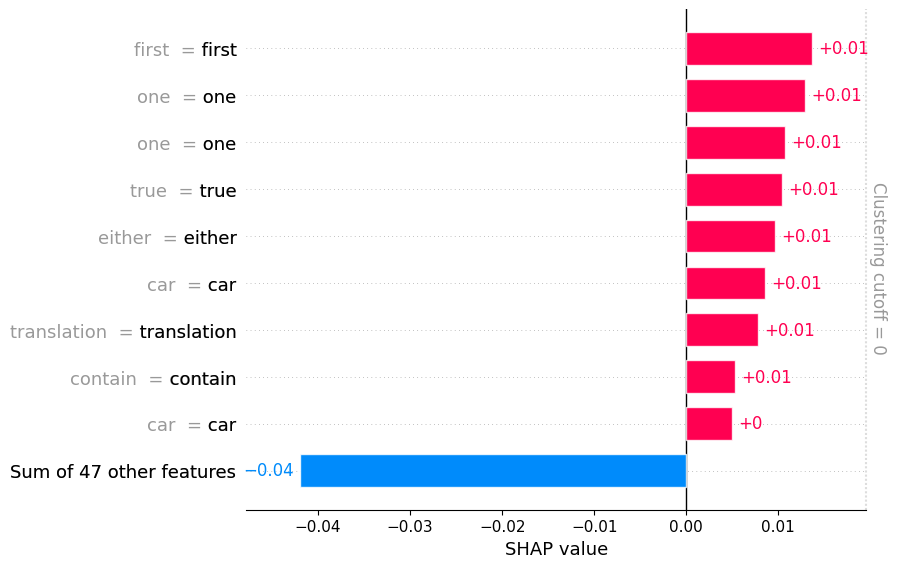

In [86]:
shap.plots.bar(svm_shapv[0,:,1], max_display=10, order=shap.Explanation.argsort.flip, clustering_cutoff=0)

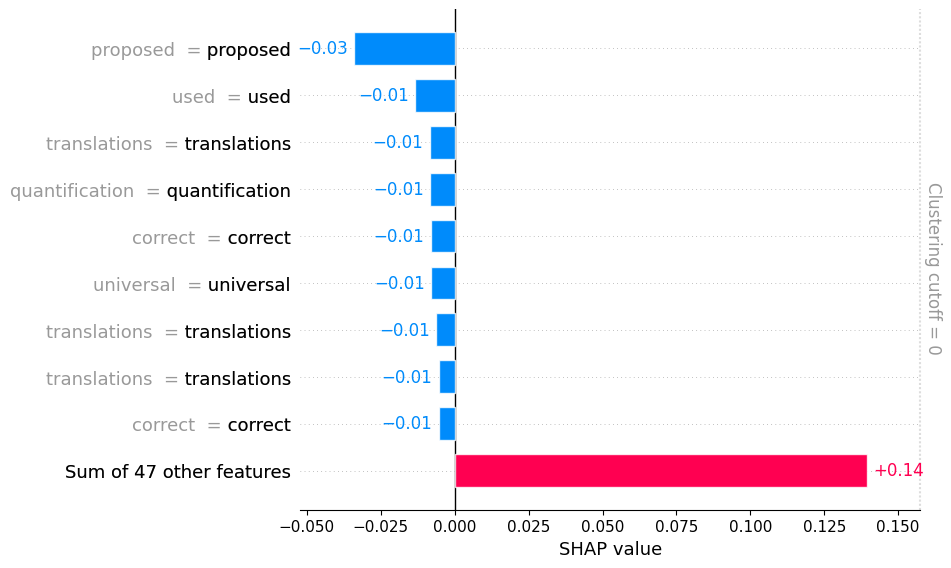

In [84]:
shap.plots.bar(svm_shapv[0,:,1], max_display=10, order=shap.Explanation.argsort, clustering_cutoff=0)

In [72]:
h["based"],g["based"]

(423, 1085)

In [56]:
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

def custom_tokenizer(s, return_offsets_mapping=True):
    """Custom tokenizers conform to a subset of the transformers API."""
    pos = 0
    offset_ranges = []
    input_ids = []
    for m in re.finditer(r"\W", s):
        start, end = m.span(0)
        offset_ranges.append((pos, start))
        input_ids.append(s[pos:start])
        pos = end
    if pos != len(s):
        offset_ranges.append((pos, len(s)))
        input_ids.append(s[pos:])
    out = {}
    out["input_ids"] = input_ids
    if return_offsets_mapping:
        out["offset_mapping"] = offset_ranges
    return out

masker = shap.maskers.Text(custom_tokenizer)
# default = shap.maskers.Text(r"\W")

In [57]:
xlnet_exp = shap.Explainer(pred, masker=masker, output_names=["gpt-generated","human-generated"])

In [58]:
xlnet_shapv = xlnet_exp([test_xlnet_text[0]])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.30s/it]                                                                                                                       


In [59]:
shap.plots.text(xlnet_shapv)

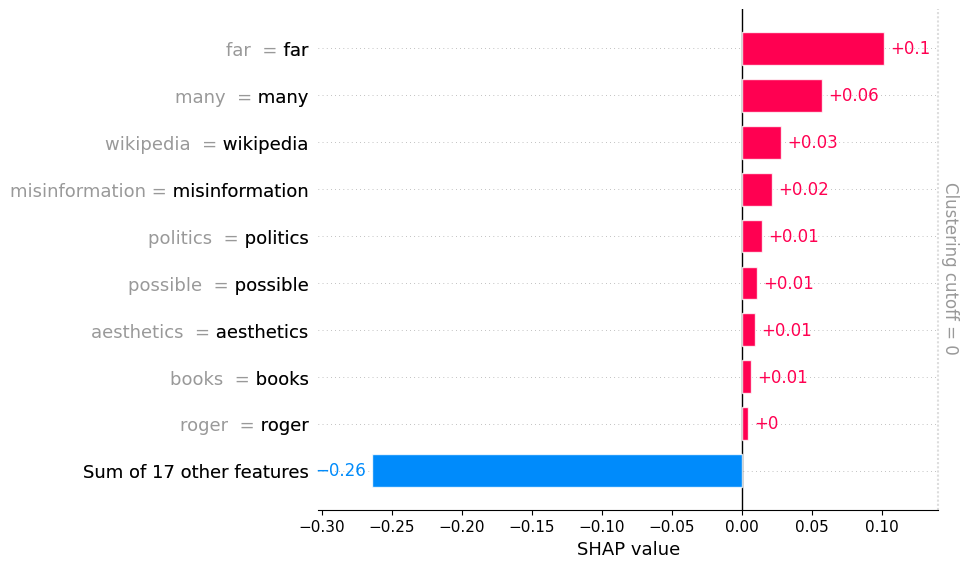

In [60]:
shap.plots.bar(xlnet_shapv[0,:,1], max_display=10, order=shap.Explanation.argsort.flip, clustering_cutoff=0)

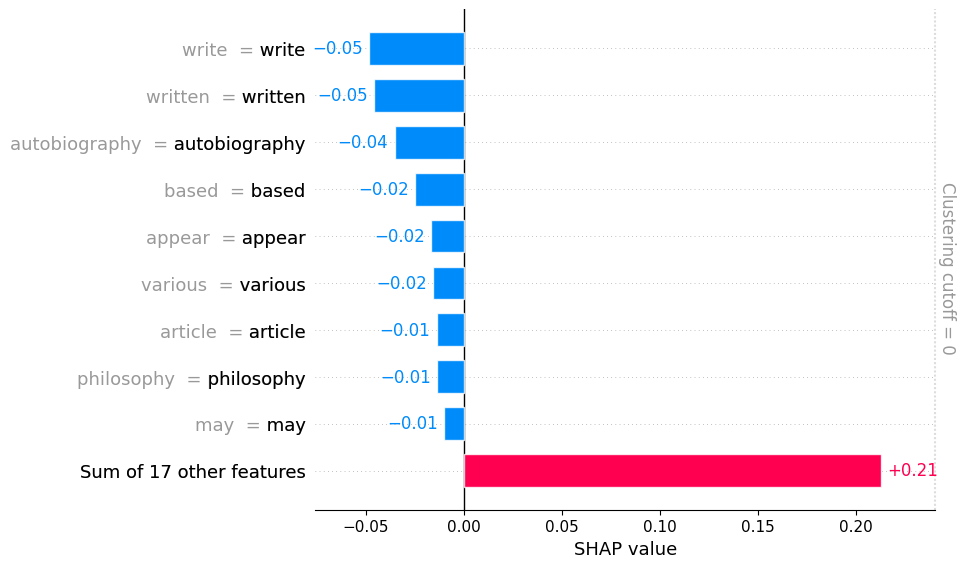

In [61]:
shap.plots.bar(xlnet_shapv[0,:,1], max_display=10, order=shap.Explanation.argsort, clustering_cutoff=0)

In [71]:
test_xlnet_text[0]

'far know roger scruton write autobiography written many books various topics including philosophy aesthetics politics appear autobiography authored possible reference wikipedia article may incorrect based misinformation'

In [72]:
import torch.nn.functional as F

class_names = ["gpt-generated", "human-generated"]

def predictor(text):
    device=torch.device("cpu")
    model.to(device)
    res = tokenizer(
        text, 
        truncation=True, 
        padding="max_length", 
        max_length=512,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
        add_special_tokens=True
    )

    with torch.no_grad():
        outputs = model(**(res).to(device))
        tensor_logits = outputs[0]
        
    probas = F.softmax(tensor_logits).numpy() # .detach().cpu().numpy()
    return probas

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(test_xlnet_text[0], predictor, num_features=10, num_samples=30) # kernel died when num_samples=35
# exp.show_in_notebook(text=correct_X[idx])

In [73]:
exp.show_in_notebook()